In [1]:
%matplotlib inline
import os
import sys
import random
import numpy as np
import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

sys.path.append(os.path.dirname(os.getcwd()))
# from pointnet.pointnet import PointNetCls, PointNetSeg

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True


# データの確認

In [3]:
num_points = 1024   # 一ケース当たりのデータ点数
num_classes = 10    # 分類クラス数
batch_size = 10
activation = 'relu' # 活性化関数

In [2]:
def read_off(file):
    first_line = file.readline().strip()
    if 'OFF' == first_line:
        n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    elif 'OFF' in first_line:
        n_verts, n_faces, __ = tuple([int(s) for s in first_line[3:].split(' ')])
    else:
        raise('Not a valid OFF header')
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

In [5]:
file_path = r"D:\Projects\deeplearning\PointNet_tf\data\ModelNet40\ModelNet40\bathtub\train\bathtub_0002.off"
with open(file_path, 'r') as f:
    mesh = read_off(f)

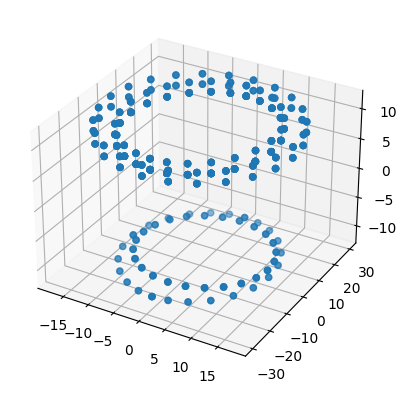

In [8]:
verts, face = mesh
verts = np.array(verts)

# 平面などは点がそこまで必要ではないためこのままでは何かわからない
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(verts[:, 0], verts[:, 1], verts[:, 2])
plt.show()

In [20]:
verts, faces = mesh
areas = np.zeros((len(faces)))
verts = np.array(verts)

# function to calculate triangle area by its vertices
# https://en.wikipedia.org/wiki/Heron%27s_formula
def triangle_area(pt1, pt2, pt3):
    side_a = np.linalg.norm(pt1 - pt2)
    side_b = np.linalg.norm(pt2 - pt3)
    side_c = np.linalg.norm(pt3 - pt1)
    s = 0.5 * ( side_a + side_b + side_c)
    return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

# we calculate areas of all faces in our mesh
for i in range(len(areas)):
    areas[i] = (triangle_area(verts[faces[i][0]],
                              verts[faces[i][1]],
                              verts[faces[i][2]]))

In [31]:
# we sample 'k' faces with probabilities proportional to their areas
# weights are used to create a distribution.
# they don't have to sum up to one.
sampled_faces = (random.choices(faces, 
                                weights=areas,
                                k=num_points))

# function to sample points on a triangle surface
def sample_point(pt1, pt2, pt3):
    # barycentric coordinates on a triangle
    # https://mathworld.wolfram.com/BarycentricCoordinates.html
    s, t = sorted([random.random(), random.random()])
    f = lambda i: s * pt1[i] + (t-s) * pt2[i] + (1-t) * pt3[i]
    return (f(0), f(1), f(2))
 
pointcloud = np.zeros((num_points, 3))

# sample points on chosen faces for the point cloud of size 'k'
for i in range(len(sampled_faces)):
    pointcloud[i] = (sample_point(verts[sampled_faces[i][0]],
                                  verts[sampled_faces[i][1]],
                                  verts[sampled_faces[i][2]]))

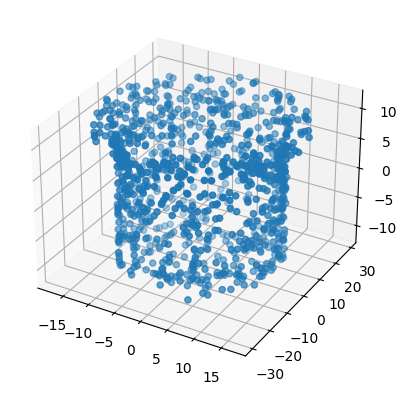

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2])
plt.show()


# データセットの準備

In [56]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_pattern, classes, num_points: int, batch_size: int=1, shuffle=False):
        if len(file_pattern) != len(labels):
            raise Exception('Invalid dataset.')
        self.file_pattern = file_pattern
        self.labels = labels
        self.classes = classes
        self.batch_size = batch_size
        self.num_points = num_points
        
        if shuffle:
            data = list(zip(self.file_pattern, self.labels))
            random.shuffle(data)
            self.file_pattern, self.labels = zip(*data)
            self.file_pattern = list(self.file_pattern)
            self.labels = list(self.labels)

    def __len__(self):
        return np.ceil(len(self.file_pattern) / self.batch_size).astype('int')

    def read_off(self, file):
        if 'OFF' != file.readline().strip():
            raise('Not a valid OFF header')
        n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
        verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
        faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
        return verts, faces
    
    def _data_parser(self, file_path):
        with open(file_path, 'r') as f:
            mesh = self.read_off(f)

        verts, faces = mesh
        areas = np.zeros((len(faces)))
        verts = np.array(verts)
        
        for i in range(len(areas)):
            areas[i] = (triangle_area(verts[faces[i][0]],
                                      verts[faces[i][1]],
                                      verts[faces[i][2]]))
        
        sampled_faces = (random.choices(faces, 
                                        weights=areas,
                                        k=self.num_points))

        pointcloud = np.zeros((self.num_points, 3))

        # sample points on chosen faces for the point cloud of size 'k'
        for i in range(len(sampled_faces)):
            pointcloud[i] = (sample_point(verts[sampled_faces[i][0]],
                                          verts[sampled_faces[i][1]],
                                          verts[sampled_faces[i][2]]))

        # standardization
        pointcloud = (pointcloud - np.mean(pointcloud, axis=0)) / np.std(pointcloud, axis=0)
        return pointcloud
    
    def _label_parser(self, label):
        onehot_label = [1 if c == label else 0 for i, c in enumerate(self.classes)]
        return onehot_label

    def __getitem__(self, idx):
        batch_file_pattern = self.file_pattern[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_labels = self.labels[idx*self.batch_size:(idx+1)*self.batch_size]
        
        batch_x = np.array([self._data_parser(path) for path in batch_file_pattern])
        batch_y = np.array([self._label_parser(label) for label in batch_labels])
        return batch_x, batch_y

In [57]:
file_pattern = list(Path(r"D:\Projects\deeplearning\PointNet_tf\data\ModelNet10\ModelNet10").glob('**/train/*.*off'))
label_pattern = [path.name.split('_')[0] for path in file_pattern]

print(len(file_pattern))
print(len(label_pattern))

3991
3991


In [58]:
random.sample(list(set(label_pattern)), 10)

['desk',
 'bathtub',
 'chair',
 'table',
 'night',
 'toilet',
 'dresser',
 'monitor',
 'bed',
 'sofa']

In [59]:
sorted(random.sample(list(set(label_pattern)), 10))

['bathtub',
 'bed',
 'chair',
 'desk',
 'dresser',
 'monitor',
 'night',
 'sofa',
 'table',
 'toilet']

In [60]:
import collections

train_x, val_x, train_y, val_y = train_test_split(file_pattern, label_pattern, test_size=0.2)

print(collections.Counter(train_y))
print(collections.Counter(val_y))

train_x, val_x, train_y, val_y = train_test_split(file_pattern, label_pattern, test_size=0.2, stratify=label_pattern)

print(collections.Counter(train_y))
print(collections.Counter(val_y))

Counter({'chair': 701, 'sofa': 535, 'bed': 408, 'monitor': 379, 'table': 314, 'toilet': 277, 'desk': 167, 'dresser': 159, 'night': 159, 'bathtub': 93})
Counter({'chair': 188, 'sofa': 145, 'bed': 107, 'monitor': 86, 'table': 78, 'toilet': 67, 'dresser': 41, 'night': 41, 'desk': 33, 'bathtub': 13})
Counter({'chair': 711, 'sofa': 544, 'bed': 412, 'monitor': 372, 'table': 313, 'toilet': 275, 'desk': 160, 'night': 160, 'dresser': 160, 'bathtub': 85})
Counter({'chair': 178, 'sofa': 136, 'bed': 103, 'monitor': 93, 'table': 79, 'toilet': 69, 'night': 40, 'dresser': 40, 'desk': 40, 'bathtub': 21})


In [61]:
data_pattern = Path(r"D:\Projects\deeplearning\PointNet\data\ModelNet10\ModelNet10").glob('**/*.*off')

train_file_pattern = []
train_label_pattern = []
test_file_pattern = []
test_label_pattern = []
for path in data_pattern:
    label = path.parents[1].name
    data_type = path.parent.name
    if data_type == 'train':
        train_file_pattern.append(str(path))
        train_label_pattern.append(label)
    elif data_type == 'test':
        test_file_pattern.append(str(path))
        test_label_pattern.append(label)

classes = list(set(train_label_pattern))

# モデルの学習

In [62]:
num_points = 1024   # 一ケース当たりのデータ点数
num_classes = 10    # 分類クラス数
batch_size = 10
activation = 'relu' # 活性化関数

In [63]:
train_gen = DataGenerator(train_file_pattern[:], train_label_pattern[:], num_points=num_points, classes=classes, batch_size=batch_size, shuffle=True)
test_gen = DataGenerator(test_file_pattern, test_label_pattern, num_points=num_points, classes=classes)

TypeError: DataGenerator.__init__() got multiple values for argument 'classes'

In [ ]:
model = PointNet(num_points, num_classes, activation)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=train_gen, epochs=20, steps_per_epoch=len(train_gen))

Epoch 1/20
400/400 [==============================] - 888s 2s/step - loss: 0.9545 - accuracy: 0.6936
Epoch 2/20
400/400 [==============================] - 863s 2s/step - loss: 0.6522 - accuracy: 0.7873
Epoch 3/20
400/400 [==============================] - 840s 2s/step - loss: 0.5107 - accuracy: 0.8239
Epoch 4/20
400/400 [==============================] - 843s 2s/step - loss: 0.4309 - accuracy: 0.8529
Epoch 5/20
400/400 [==============================] - 841s 2s/step - loss: 0.3761 - accuracy: 0.8727
Epoch 6/20
400/400 [==============================] - 829s 2s/step - loss: 0.3379 - accuracy: 0.8805
Epoch 7/20
400/400 [==============================] - 844s 2s/step - loss: 0.3129 - accuracy: 0.8925
Epoch 8/20
400/400 [==============================] - 852s 2s/step - loss: 0.2851 - accuracy: 0.9005
Epoch 9/20
400/400 [==============================] - 861s 2s/step - loss: 0.2641 - accuracy: 0.9065
Epoch 10/20
400/400 [==============================] - 837s 2s/step - loss: 0.2352 - accura

In [4]:
data = np.loadtxt(r"D:\Projects\deeplearning\PointNet_tf\data\modelnet40_normal_resampled\modelnet40_normal_resampled\airplane\airplane_0001.txt", delimiter=',')

In [21]:
data[:10, :].shape

(10, 6)

In [8]:
root_dir = r"D:\Projects\deeplearning\PointNet_tf\data\modelnet40_normal_resampled"
split = 'train'

In [33]:
file_txt_path = os.path.join(root_dir, f'modelnet40_{split}.txt')
with open(file_txt_path, 'r') as f:
    file_names = [line.rstrip() for line in f.readlines()]

file_pattern = [os.path.join(root_dir, name[:-5], f'{name}.txt') for name in file_names]

In [34]:
file_pattern

['D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\airplane\\airplane_0001.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\airplane\\airplane_0002.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\airplane\\airplane_0003.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\airplane\\airplane_0004.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\airplane\\airplane_0005.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\airplane\\airplane_0006.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\airplane\\airplane_0007.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\airplane\\airplane_0008.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\airplane\\airplane_0009.txt',
 'D:\\Projects\\deeplearning

In [35]:
random.sample(file_pattern, len(file_pattern))

['D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\bookshelf\\bookshelf_0077.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\car\\car_0100.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\chair\\chair_0751.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\plant\\plant_0231.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\mantel\\mantel_0104.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\bathtub\\bathtub_0006.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\tv_stand\\tv_stand_0152.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\tv_stand\\tv_stand_0103.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\cone\\cone_0122.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_no

In [32]:
file_pattern

['D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\airplane\\airplane_0572.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\tv_stand\\tv_stand_0212.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\stairs\\stairs_0122.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\chair\\chair_0629.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\vase\\vase_0205.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\bottle\\bottle_0124.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\airplane\\airplane_0050.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\bench\\bench_0075.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_normal_resampled\\bottle\\bottle_0209.txt',
 'D:\\Projects\\deeplearning\\PointNet_tf\\data\\modelnet40_